In [ ]:
# tutorial from: https://osf.io/j8kby/
# tutorial is based on openCV 3.1.0 but we use 4.4.0 
# adjusted typos in the code (brackets and trailing spaces)
# adjusted findTransformECC (had to set 6th parameter to none and 7th to 5) --> documentation https://docs.opencv.org/3.4/dc/d6b/group__video__track.html#ga1aa357007eaec11e9ed03500ecbcbe47

In [1]:
%matplotlib inline
import cv2
#import imutils
from matplotlib import pyplot as plt
import numpy as np
#import time as t
import os
import glob
import time

In [2]:
print("OpenCV Version : %s " % cv2.__version__)

OpenCV Version : 4.4.0 


In [3]:
def load_images(dir_name, file_name_pattern):
    image_paths = glob.glob(os.path.join(dir_name, file_name_pattern))
    image_paths.sort()
    images = []
    for image_path in image_paths:
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        images.append(image)
    return images

In [4]:
'''
Takes two RGB images, im1 and im2, and returns a third RGB image which is aligned with im1.
Using a warp_mode other than cv2.MOTION_TRANSLATION takes a very, very long time and does not significantly
improve image quality.
'''
def align(im1, im2):

    # Convert images to grayscale
    im1_gray = cv2.cvtColor(im1,cv2.COLOR_RGB2GRAY)
    im2_gray = cv2.cvtColor(im2,cv2.COLOR_RGB2GRAY)

    # Find size of image1
    sz = im1.shape

    # Define the motion model
    warp_mode = cv2.MOTION_TRANSLATION
    # warp_mode = cv2.MOTION_HOMOGRAPHY
    # warp_mode = cv2.MOTION_AFFINE

    # Define 2x3 or 3x3 matrices and initialize the matrix to identity
    if warp_mode == cv2.MOTION_HOMOGRAPHY :
        warp_matrix = np.eye(3, 3, dtype=np.float32)
    else :
        warp_matrix = np.eye(2, 3, dtype=np.float32)

    # Specify the number of iterations.
    number_of_iterations = 5000

    # Specify the threshold of the increment
    # in the correlation coefficient between two iterations
    termination_eps = 1e-10

    # Define termination criteria
    criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, number_of_iterations,  termination_eps)

    # Run the ECC algorithm. The results are stored in warp_matrix.
    (cc, warp_matrix) = cv2.findTransformECC(im1_gray,im2_gray,warp_matrix, warp_mode, criteria, None, 5)

    if warp_mode == cv2.MOTION_HOMOGRAPHY :
        # Use warpPerspective for Homography 
        im2_aligned = cv2.warpPerspective(im2, warp_matrix, (sz[1],sz[0]), 
                                           flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)
    else :
        # Use warpAffine for Translation, Euclidean and Affine
        im2_aligned = cv2.warpAffine(im2, warp_matrix, (sz[1],sz[0]), 
                                     flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)
    return im2_aligned

In [25]:
'''
Aligns images to an image at or near the middle of the stack
'''
def align_images(images):
    im0 = images[int(len(images)/2)]
    aligned_image_list = []
    for im in images:
        print('   ALIGNING image')
        aligned_image_list.append(align(im0, im))
    return aligned_image_list

#
#   Compute the gradient map of the image
def doLap(image):

    # YOU SHOULD TUNE THESE VALUES TO SUIT YOUR NEEDS
    kernel_size = 11         # Size of the laplacian window
    blur_size = 11           # How big of a kernal to use for the gaussian blur
                            # Generally, keeping these two values the same or very close works well
                            # Also, odd numbers, please...

    blurred = cv2.GaussianBlur(image, (blur_size,blur_size), 0)
    return cv2.Laplacian(blurred, cv2.CV_64F, ksize=kernel_size)

#
#   This routine finds the points of best focus in all images and produces a merged result...
#
def focus_stack(unimages):
    images = align_images(unimages)

    print('   FOCUS-STACKING')
    laps = []
    for i in range(len(images)):
        #print "Lap {}".format(i)
        laps.append(doLap(cv2.cvtColor(images[i],cv2.COLOR_BGR2GRAY)))

    laps = np.asarray(laps)
    #print "Shape of array of laplacians = {}".format(laps.shape)

    output = np.zeros(shape=images[0].shape, dtype=images[0].dtype)

    for y in range(0,images[0].shape[0]):
        for x in range(0, images[0].shape[1]):
            yxlaps = abs(laps[:, y, x])
            index = (np.where(yxlaps == max(yxlaps)))[0][0]
            output[y,x] = images[index][y,x]
    return output

In [27]:

start_time = time.clock()
file_name_pattern = '*.jpeg'
# dir_name = point to folder where imgs are
for dir_name in ['/Users/nijeri/Documents/Malaria Project/Pictures/scan_clean/scan_1']:
    print('LOADING files in {}'.format(dir_name))
    images = load_images(dir_name, file_name_pattern)
    im = focus_stack(images)

    # Save image in a file, 'focus_stacked.png', in the same directory as the other images
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    cv2.imwrite(dir_name+'/focus_stacked_11_11.png',im)    
print('FINISHED')
print('Processor time: {} seconds'.format(time.clock() - start_time))

LOADING files in /Users/nijeri/Documents/Malaria Project/Pictures/scan_clean/scan_1
   ALIGNING image
   ALIGNING image
   ALIGNING image
   ALIGNING image
   ALIGNING image
   FOCUS-STACKING
FINISHED
Processor time: 93.11910300000011 seconds


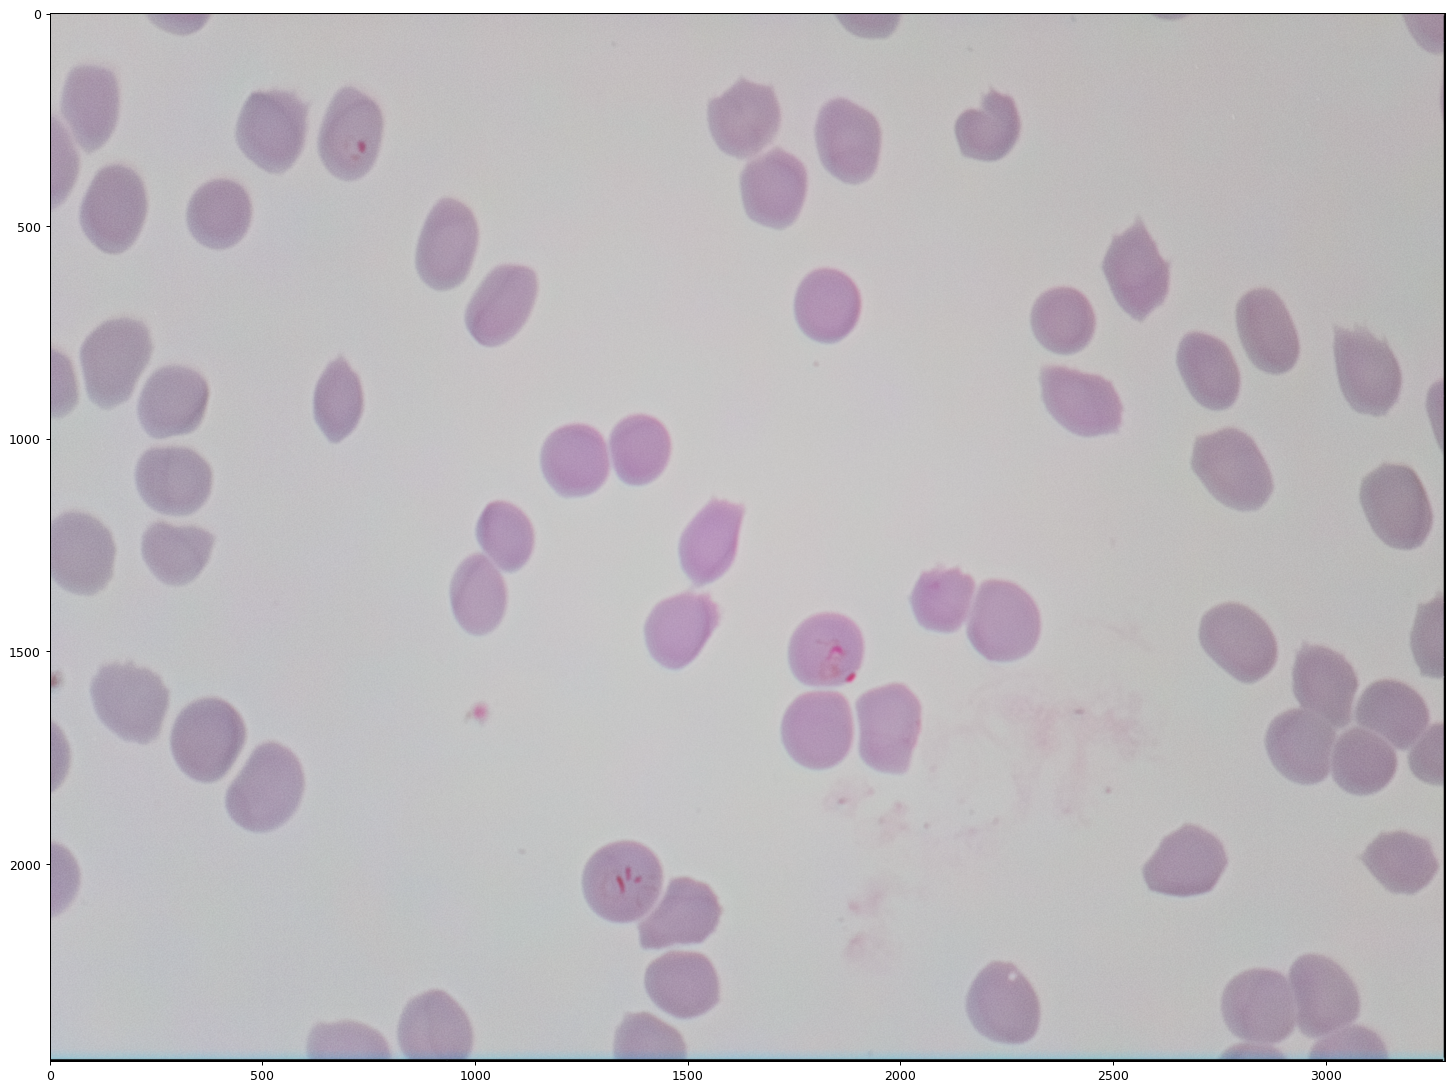

In [23]:
#Display Stacked Image

fig = plt.figure(1, figsize=(20,20), dpi=90)
plt.imshow(im)

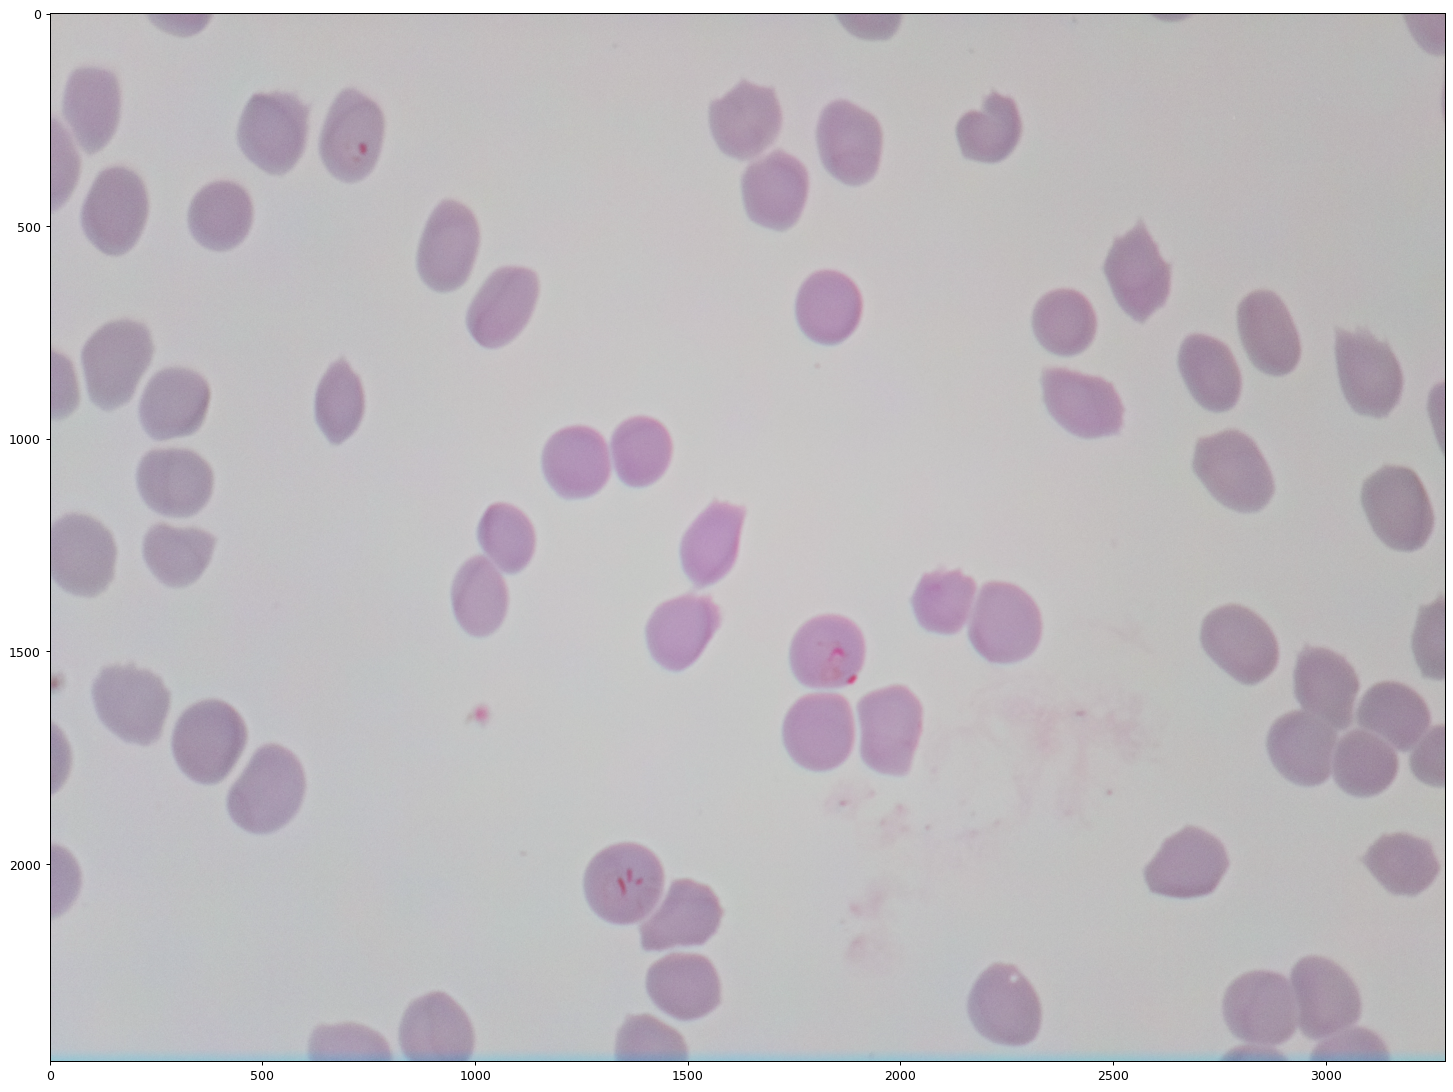

In [24]:
# Display one of the original images

non_stacked = cv2.imread("/Users/nijeri/Documents/Malaria Project/Pictures/scan_clean/scan_1/2021-03-05_15-50-16_0_0_5574.jpeg")
fig = plt.figure(1, figsize=(20,20), dpi=90)
plt.imshow(non_stacked)